In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_state_qsphere
from qiskit.quantum_info import Operator

In [2]:
# visualize eigenstate
def to_bloch_vector(ucirc, statevector):
    new_state = statevector.evolve(ucirc)
    bloch_vector = [
    new_state.expectation_value(Operator([[0, 1], [1, 0]])).real, # X
    new_state.expectation_value(Operator([[0, -1j], [1j, 0]])).real, # Y
    new_state.expectation_value(Operator([[1, 0], [0, -1]])).real # Z
    ]
    return bloch_vector
# visualize eigenvalue
def plot_complex_nmb(phasors):
    # Create a new figure
    plt.figure(figsize=(4, 4))
    # plot each phasor as a vector
    for phasor in phasors:
        real = np.real(phasor)
        imag = np.imag(phasor)
        plt.quiver(0, 0, real, imag, angles='xy', scale_units='xy', scale=1, color='r')
        plt.text(real * 1.1, imag * 1.1, f'{phasor:.2f}', fontsize=12)
    # set up the plot axes
    plt.xlim(-2, 2) # Adjust these limits based on your phasors
    plt.ylim(-2, 2)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Phasor Diagram')
    # show the plot
    plt.show()    

In [9]:
# find eigenvalue and eigenstate
# Define the angle for Rx
theta = np.pi / 3

# Define the Rx matrix for the given theta
Rx = np.array([[np.cos(theta / 2), -1j * np.sin(theta / 2)],
               [-1j * np.sin(theta / 2), np.cos(theta / 2)]])

# Use numpy to find the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(Rx)

# Display the eigenvalues and eigenvectors
print("Eigenvalues of Rx(pi/3):")
print(eigenvalues)

print("\nEigenstates of Rx(pi/3):")
for i, eigenvector in enumerate(eigenvectors.T):
    print(f"Eigenstate {i + 1}:")
    print(eigenvector)

Eigenvalues of Rx(pi/3):
[0.8660254+0.5j 0.8660254-0.5j]

Eigenstates of Rx(pi/3):
Eigenstate 1:
[-0.70710678-0.j  0.70710678+0.j]
Eigenstate 2:
[0.70710678+0.j 0.70710678+0.j]


In [23]:
np.exp(-1j*theta/2)

np.complex128(0.8660254037844387-0.49999999999999994j)

In [22]:
Rx @ eigenvectors[1] / eigenvalues[1] - eigenvectors[1]

array([1.11022302e-16-2.10709495e-17j, 1.11022302e-16-2.10709495e-17j])

In [3]:
phi = np.pi/3
ucirc = QuantumCircuit(1,1)
ucirc.rx(phi,0)
state0 = Statevector([1,0])
state1 = Statevector([0,1])
plus = (state0+state1)/np.sqrt(2)
minus = (state0-state1)/np.sqrt(2)
bloch_0 = to_bloch_vector(ucirc, plus)
bloch_1 = to_bloch_vector(ucirc, minus)
# plot the Bloch vector
plot_bloch_vector([bloch_0, bloch_1]).savefig('bloch.pdf')

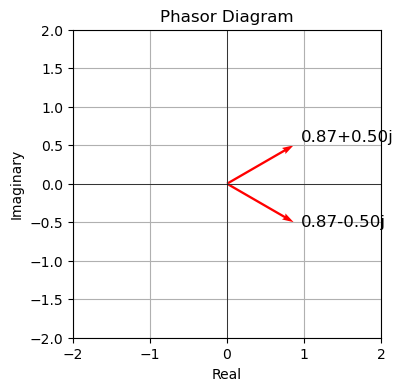

In [4]:
phasors = [np.exp(-0.5j*phi), np.exp(0.5j*phi)]
plot_complex_nmb(phasors)

In [7]:
# create quantum circuit
qc = QuantumCircuit(5, 4)
# prepare eigenstate
qc.x(4)
qc.h(4)
# step 1: add hadamard
for qubit in range(4):
    qc.h(qubit)
    qc.barrier()
# step 2: controlled unitary operations
for reg1_index in range(4):
    repetitions = 2**reg1_index 
    for i in range(repetitions):
        qc.crx(phi, reg1_index, 4)
qc.barrier()
# step 3: IQFT on the first register
iqft = QFT(num_qubits=4, inverse=True, insert_barriers=True)
qc.append(iqft, [0,1,2,3])
qc.barrier()
# step 4: measurement
for reg1_index in range(4):
    qc.measure(reg1_index, reg1_index)
qc.draw(output='mpl').savefig('qpe_4.pdf')
sampler = Sampler()
job = sampler.run(circuits=qc, shots=5000)
result = job.result()

/var/folders/sn/4ym_qb8x0cs_f961d78kvvkc0000gn/T/ipykernel_53629/1494548031.py:24: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


In [8]:
# get the result counts and convert quasi-probabilities to probabilities
counts = result.quasi_dists[0].binary_probabilities()
# print result
print("Measuremet result:", result.quasi_dists[0])
# plot the result as a histogram
plt.rc('font', family='serif', serif='Times New Roman')
plot_histogram(counts, figsize=(8,4.5)).savefig('hist_4.pdf')

Measuremet result: {0: np.float64(0.0428), 1: np.float64(0.6804), 2: np.float64(0.1792), 3: np.float64(0.024), 4: np.float64(0.012), 5: np.float64(0.0086), 6: np.float64(0.0038), 7: np.float64(0.003), 8: np.float64(0.003), 9: np.float64(0.003), 10: np.float64(0.0038), 11: np.float64(0.0026), 12: np.float64(0.0036), 13: np.float64(0.0064), 14: np.float64(0.009), 15: np.float64(0.0148)}
